# Hydrological Modeling

## Introduction

In this tutorial, we demonstrate capabilities of the `sceua` package through calibration of HYdrological MODel [(HYMOD)](https://piahs.copernicus.org/articles/368/180/2015/piahs-368-180-2015.pdf) for a watershed in the US. We obtain the required input data for running the model from various web services. HYMOD is a parsimonious conceptual rainfall-runoff model that operates on a daily time step. It is based on the theory of runoff yield under excess infiltration and employs a probability-distributed principle to describe the spatial variability of water storage capacity within a basin.

The model structure incorporates components for runoff generation and routing, dividing runoff into quick flow (routed through three identical quick flow tanks) and slow flow (routed through a parallel slow flow tank) based on model parameters. The figure below illustrates the flowchart of HYMOD:

<img src="https://raw.githubusercontent.com/hyriver/hysetter/main/docs/examples/images/hymod-flowchart.png" alt="HYMOD Flowchart" style="width: 500px;"/>

The model parameters and their ranges are presented in the following table:

| Parameter | Description | Range |
| --- | --- | --- |
| $C_\mathrm{max}$ | Maximum storage capacity | 1-1500 [mm] |
| $B_\mathrm{exp}$ | Degree of spatial variability of the soil moisture capacity | 0-2 [-] |
| $\alpha$ | Factor for dividing flow into slow and quick releases | 0-1 [-] |
| $K_s$ | Residence time of the slow release reservoir | 0-0.14 [day $^{-1}$] |
| $K_q$ | Residence time of the three quick release reservoirs | 0.14-1 [day $^{-1}$] |

## Model Implementation

First, let's implement the model using `numpy` and `numba`.

In [1]:
from __future__ import annotations

import numpy as np
import numpy.typing as npt
from numba import config as numba_config
from numba import njit

numba_config.THREADING_LAYER = "workqueue"

FloatArray = npt.NDArray[np.float32]


@njit(nogil=True)
def _linear_reservoir(
    x_slow: np.float32, inflow: np.float32, k_s: np.float32
) -> tuple[np.float32, np.float32]:
    """Run the linear reservoir model."""
    xn_slow = (1 - k_s) * x_slow + (1 - k_s) * inflow
    outflow = k_s / (1 - k_s) * xn_slow
    return xn_slow, outflow


@njit(nogil=True)
def _excess(
    prcp_t: np.float32,
    pet_t: np.float32,
    x_loss: np.float32,
    c_max: np.float32,
    b_exp: np.float32,
) -> tuple[np.float32, np.float32]:
    """Calculate excess precipitation and evaporation."""
    ct_prev = c_max * (1 - np.power(np.abs(1 - ((b_exp + 1) * (x_loss) / c_max)), 1 / (b_exp + 1)))
    er_1 = np.maximum(prcp_t - c_max + ct_prev, 0)
    s_1 = prcp_t - er_1
    dummy = np.minimum((ct_prev + s_1) / c_max, 1)
    xn = c_max / (b_exp + 1) * (1 - np.power(np.abs(1 - dummy), b_exp + 1))

    er_2 = np.maximum(s_1 - (xn - x_loss), 0.2)

    evap = (1 - (((c_max / (b_exp + 1)) - xn) / (c_max / (b_exp + 1)))) * pet_t
    xn = np.maximum(xn - evap, 0)

    return er_1 + er_2, xn


@njit(nogil=True)
def run_hymod(
    prcp: FloatArray,
    pet: FloatArray,
    c_max: np.float32,
    b_exp: np.float32,
    alpha: np.float32,
    k_s: np.float32,
    k_q: np.float32,
) -> FloatArray:
    """Run HYMOD model."""
    x_loss = np.float32(0.0)
    x_slow = np.float32(0.0)
    outflow = np.float32(0.0)
    x_quick = np.zeros(3, dtype="f4")
    n_steps = prcp.shape[0]
    q_out = np.zeros(n_steps, dtype="f4")

    for t in range(n_steps):
        et, x_loss = _excess(prcp[t], pet[t], x_loss, c_max, b_exp)
        u_q = alpha * et
        u_s = (1 - alpha) * et
        x_slow, q_s = _linear_reservoir(x_slow, u_s, k_s)
        inflow = u_q
        for i in range(3):
            x_quick[i], outflow = _linear_reservoir(x_quick[i], inflow, k_q)
            inflow = outflow
        q_out[t] = q_s + outflow
    return q_out

## Data Preparation

For calibrating the model parameters, we use the SCE-UA algorithm. We use the observed streamflow data for calibration with Nash-Sutcliffe Efficiency (NSE) as the objective function.

To run the model, we require the following data:
1. Upstream drainage area of the target watersheds
2. Forcing data (precipitation and potential evapotranspiration, PET)
3. Daily streamflow observations at the watersheds' outlets

The most convinient way of obtaining is using [HyRiver](https://docs.hyriver.io) software stack or[HySetter](https://hysetter.readthedocs.io/latest/) which is build on top of HyRiver. The HyRiver packages provide access to many web services and APIs to acquire the data that we need for this tutorial. However, for simplicity, we directly use the the web services to obtain the data.

We select [01666500](https://waterdata.usgs.gov/monitoring-location/01666500/#parameterCode=00065&period=P7D&showMedian=false) as the target watershed.

In [2]:
import json
from pathlib import Path
from urllib.parse import urlencode
from urllib.request import urlopen, urlretrieve

import geopandas as gpd
import pandas as pd
import xarray as xr

In [3]:
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)
station_id = "01666500"

Let's start by getting the geometry of the upstream drainage area of this watershed. We use the [NLDI](https://waterdata.usgs.gov/blog/nldi-intro/) web service. Alternatively, we can use [PyNHD](https://docs.hyriver.io/readme/pynhd.html) to get the watershed data.

In [4]:
basin = gpd.read_file(
    f"https://api.water.usgs.gov/nldi/linked-data/nwissite/USGS-{station_id}/basin"
)
geometry = basin.union_all()
geo_crs = basin.crs
area_sqm = basin.to_crs(5070).area.sum()

In [5]:
basin.explore()

For getting streamflow observations we use the [NWIS](https://waterdata.usgs.gov/nwis/) web service. Note that the streamflow data in NWIS is in cubic feet per second, so we need to convert it to millimeters per day. We do so by multiplying the streamflow data by 0.02832 (to cubic meter per second), 86,400 (the number of seconds in a day), and 1,000 (to convert from m to mm), then dividing by the watershed area. Alternaitively, we can use [PyGeoHydro](https://docs.hyriver.io/readme/pygeohydro.html) to obtain the streamflow data.

In [6]:
url = f"https://waterservices.usgs.gov/nwis/dv/?format=json&sites={station_id}&startDT=2000-01-01&endDT=2019-12-31&parameterCd=00060"
data = json.loads(urlopen(url).read())
qobs = pd.Series(
    {
        v["dateTime"]: v["value"]
        for d in data["value"]["timeSeries"]
        for v in d["values"][0]["value"]
    }
)
qobs = qobs.astype("f4") * 0.02832 * (24 * 3600) * 1e3 / area_sqm
qobs.index = pd.to_datetime(qobs.index)
qobs.name = "qobs"

Next, let's get the forcing data for the watersheds from [GridMET](https://www.climatologylab.org/gridmet.html). Note that since HYMOD is a lump model, we must aggregate the data to the watershed scale. Alternatively, we can use [PyGridMET](https://docs.hyriver.io/readme/pygridmet.html) to obtain the forcing data.

In [7]:
west, south, east, north = geometry.bounds


def get_url(short: str, long: str) -> str:
    base_url = f"http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_met_{short}_1979_CurrentYear_CONUS.nc"
    params = {
        "var": long,
        "north": round(north, 6),
        "west": round(west, 6),
        "east": round(east, 6),
        "south": round(south, 6),
        "horizStride": 1,
        "time_start": "2000-01-01T00:00:00Z",
        "time_end": "2019-12-31T00:00:00Z",
        "timeStride": 1,
        "addLatLon": "true",
        "accept": "netcdf",
    }
    return f"{base_url}?{urlencode(params)}"


var_names = {"precipitation_amount": "pr", "daily_mean_reference_evapotranspiration_grass": "pet"}
nc_files = []
for long, short in var_names.items():
    nc_file = data_dir / f"{short}.nc"
    nc_files.append(nc_file)
    if not nc_file.exists():
        urlretrieve(get_url(short, long), nc_file)
clm = xr.merge(xr.open_dataset(f) for f in nc_files).rename(var_names)
clm = clm.rio.write_crs(4326).rio.clip([geometry], crs=geo_crs)
clm = clm.mean(dim=["lat", "lon"]).to_dataframe()[var_names.values()]

For calibration, we need to ensure that the dates of the streamflow data match those of the forcing data. We can do this by filtering both datasets to their common dates.

In [8]:
idx = qobs.index.intersection(clm.index)
qobs = qobs.loc[idx]
clm = clm.loc[idx]

## Calibration

We use SCE-UA to calibrate the model parameters. The objective function is the Nash-Sutcliffe Efficiency (NSE) metric. For this purpose, we need to define a function that gets as input a set of parameters and returns the NSE value. The best way to achieve this is to define a class with a `fit` method that takes the parameters as input and returns the NSE value. Note that, `scipy` minimizes the objective function, so we need to negate the NSE value.

In [9]:
@njit(nogil=True)
def compute_nse(sim: FloatArray, obs: FloatArray) -> float:
    """Compute Nash-Sutcliffe Efficiency."""
    nse = 1 - np.sum(np.square(obs - sim)) / np.sum(np.square(obs - np.mean(obs)))
    return nse


class HYMOD:
    """Simulate a watershed using HYMOD model."""

    def __init__(self, clm: pd.DataFrame, qobs: pd.Series, warmup_years: int) -> None:
        if not all(clm.columns.intersection(["pr", "pet"]) == ["pr", "pet"]):
            raise ValueError("clm must contain 'pr' and 'pet' columns")
        if len(clm) != len(qobs):
            raise ValueError("clm and qobs must have the same length")
        if len(qobs) < 365 * warmup_years:
            raise ValueError("Not enough data for the warmup period")
        self.prcp = clm["pr"].to_numpy("f4")
        self.pet = clm["pet"].to_numpy("f4")
        self.qobs = qobs.to_numpy("f4")
        self.cal_idx = np.s_[warmup_years * 365 :]

    def __call__(self, x: FloatArray) -> FloatArray:
        """Simulate the watershed."""
        c_max, b_exp, alpha, k_s, k_q = x.astype("f4")
        return run_hymod(self.prcp, self.pet, c_max, b_exp, alpha, k_s, k_q)

    def fit(self, x: FloatArray) -> float:
        """Compute objective functions (NSE)."""
        qsim = self(x)
        nse = compute_nse(qsim[self.cal_idx], self.qobs[self.cal_idx])
        return -nse

Now, we can calibrate the model for the watershed and obtain the best parameters.

THe SCE-UA package implements an improved version of the original SCE-UA algorithm. There's one main parameter that we need to set: the number of complexes. A good starting point for this paramere is three times the number of parameters. In our case, we have five parameters, so we set the number of complexes to 15. If the results are not satisfactory, we can increase the number of complexes to 20 or 30 times the number of parameters. Just note that this will increase the computation time.

In [10]:
import sceua

bounds = {
    "c_max": (1, 1500),
    "b_exp": (0.0, 1.99),
    "alpha": (0.01, 0.99),
    "k_s": (0.01, 0.14),
    "k_q": (0.14, 0.99),
}
cal_idx = int(0.7 * clm.shape[0])
model = HYMOD(clm.iloc[:cal_idx], qobs.iloc[:cal_idx], 1)
results = sceua.minimize(model.fit, list(bounds.values()), n_complexes=3 * len(bounds), seed=42)
best_params = pd.Series(results.x, index=list(bounds)).round(3)
best_params

c_max    273.302
b_exp      0.402
alpha      0.706
k_s        0.031
k_q        0.675
dtype: float64

We can use the `results` object to plot the convergence rate and cumulative regret curves which are important for understanding the performance of the optimization. Ideally, we want both curves to plateau.

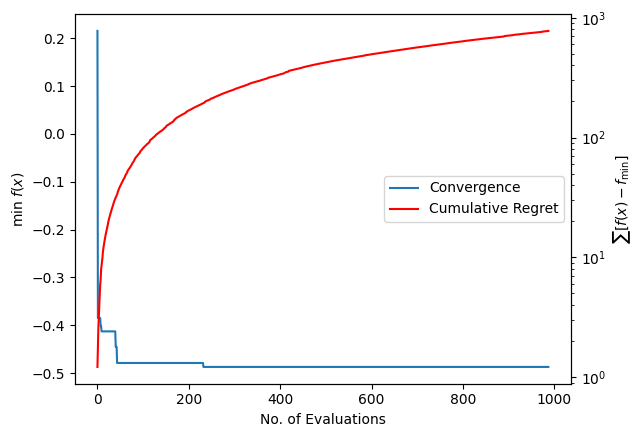

In [11]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.set_xlabel("No. of Evaluations")
ax1.set_ylabel(r"$\min\ f(x)$")
ax1.plot(np.minimum.accumulate(results.funv))

ax2 = ax1.twinx()
ax2.set_yscale("log")
ax2.set_ylabel(r"$\sum \left[ f(x) - f_\mathrm{min} \right]$")
func_min = -1
ax2.plot(np.cumsum(results.funv - func_min), color="r")
_ = fig.legend(
    ["Convergence", "Cumulative Regret"],
    loc="right",
    bbox_to_anchor=(1, 0.5),
    bbox_transform=ax1.transAxes,
)
fig.savefig("images/convergence.png", dpi=100, bbox_inches="tight")

Now, let's plot the observed and simulated streamflow for the watershed. For this purpose, we can use one of the HyRiver packages called [HydroSignature](https://docs.hyriver.io/readme/hydrosignatures.html) to plot hydrologic signatures and measure the goodness of fit.

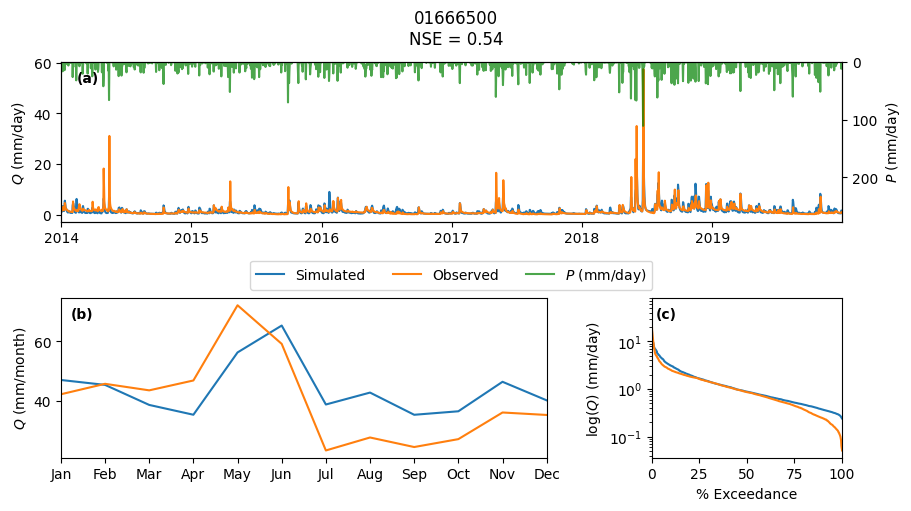

In [12]:
import hydrosignatures as hs

model = HYMOD(clm, qobs, 0)
qsim = model(results.x)
nse = compute_nse(qsim[cal_idx:], model.qobs[cal_idx:])
discharge = pd.DataFrame(
    {"Simulated": qsim[cal_idx:], "Observed": model.qobs[cal_idx:]},
    index=qobs.iloc[cal_idx:].index,
)
_ = hs.plot.signatures(
    discharge,
    clm.iloc[cal_idx:].pr,
    title=f"{station_id}\nNSE = {nse:.2f}",
)

As the plots demonstrate, the model is able to capture the streamflow dynamics relatively well for the watershed with NSE values larger than 0.5.

## Final Remarks

This tutorial, demonstrated the power of the `sceua` package for hydrological modeling. We used the SCE-UA algorithm to calibrate the HYMOD model for a watershed in the US. The model was able to capture the streamflow dynamics relatively well, with NSE values larger than 0.5. The `sceua` package is a powerful and fast tool for hydrological modeling and can be used for various applications in hydrology.